**Importing necessary libraries for data visualization and manipulation :**

In [69]:
# Importing necessary libraries for data visualization and manipulation
import random  # Used for generating random numbers and random selections

# Used for creating static, interactive, and animated visualizations in Python
import matplotlib.pyplot as plt

# Used for creating custom line markers within plots
from matplotlib.lines import Line2D

# Provides a way of using operating system dependent functionality like reading or writing to a file system
import os

# Implements binary protocols for serializing and de-serializing a Python object structure.
import pickle

# Data manipulation and analysis library, essential for handling data in DataFrames
import pandas as pd

# Fundamental package for scientific computing with Python, especially useful for array operations
import numpy as np

# Represents a duration, the difference between two dates or times. Often used for time series analysis
from datetime import timedelta

# Subpackage for interpolation which provides functions to deal with interpolation algorithms, such as spline interpolation
from scipy import interpolate

# Provides functions for splitting datasets into random train and test subsets
from sklearn.model_selection import train_test_split

# Functions for performing B-spline representation and evaluation
from scipy.interpolate import splrep, splev, CubicSpline

# Provides functions for calculating performance metrics like Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

# Provides functions for deep copying, which is useful when making independent copies of objects that should not be linked to the original
import copy

**Load the data:**

In [71]:
#directory = "C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/Proper Windows/proper_windows.pkl"
directory = 'C:/Users/adior/Documents/Digital Medical Tech - degree/Final Mop Project/Train Files/proper_windows/proper_windows.pkl'

with open(directory, 'rb') as f:
    proper_windows = pickle.load(f)

# Create a new dictionary with simple integer keys
proper_windows_dict = {i: proper_windows[key].reset_index(drop=True) for i, key in enumerate(proper_windows.keys())}

In [73]:
len(proper_windows_dict)

277

**Find the min number of min_peaks in our windows, to figure out the min number of cycles holes synthezis for later use:**

In [75]:
def find_min_cycle_count(proper_windows):
    """
    Finds the minimum amount of cycles across all windows, considering only the 7 seconds in the middle of the window (rows 250-950).

    Parameters:
    proper_windows (dict): A dictionary where each key corresponds to a dataframe.
                           Each dataframe contains a column 'is_min_peak' which is a boolean indicating the presence of a cycle peak.

    Returns:
    int: The minimum count of True values in the 'is_min_peak' column across all windows minus 1,
         which represents the minimum amount of cycles across all windows.
    """

    # Initialize min_peak_count with infinity to ensure any count found will be smaller
    min_peak_count = float('inf')

    # Iterate over each dataframe in the proper_windows dictionary
    for key, df in proper_windows.items():
        
        # Select only the middle section of the dataframe, rows 250 to 950, representing 7 seconds of data
        middle_section = df.iloc[250:950]
        
        # Count the number of True values in the 'is_min_peak' column within the middle section
        true_count = middle_section['is_min_peak'].sum()
        
        # Update min_peak_count if the current true_count is smaller than the current min_peak_count
        if true_count < min_peak_count:
            min_peak_count = true_count

    # Subtract 1 from the minimum peak count to get the minimum cycle count
    min_cycle_count = min_peak_count - 1

    # Return the minimum cycle count across all windows
    return min_cycle_count

In [77]:
# Calculate the minimum cycle count across all windows in the proper_windows_dict dictionary
min_cycle_count = find_min_cycle_count(proper_windows_dict)

# Print the result, displaying the minimum count of cycles across all windows.
print(f"The minimum count of cycles across all windows is {min_cycle_count}.")

The minimum count of cycles across all windows is 4.


**Function that choose specific amount of windows from proper_windows:**

In [79]:
def select_random_windows(windows_dict, X):
    """
    Selects specific amount of random windows from proper_windows.

    Parameters:
    windows_dict (dict): The dictionary containing the windows.
    X (int): The number of windows to select.

    Returns:
    dict: A new dictionary containing the selected windows.
    """
    if X > len(windows_dict):
        print(f"{X} is greater than the number of windows in the dictionary. Returning the entire dictionary with {len(windows_dict)} windows.")
        return windows_dict

    selected_keys = random.sample(list(proper_windows_dict.keys()), X)
    training_windows_dict = {key: proper_windows_dict[key] for key in selected_keys}

    return training_windows_dict

In [81]:
training_windows_dict = select_random_windows(proper_windows_dict, 500)

500 is greater than the number of windows in the dictionary. Returning the entire dictionary with 277 windows.


**Creating synthetic holes in duplicated windows with realistic distribution:**

In [90]:
def synthetic_holes_creation_original(training_windows_dict, min_cycle_count):
    """
    Duplicates each window by the number of min_cycle_count found and performs additional processing.

    Parameters:
    training_windows_dict (dict): A dictionary containing the selected windows.
    min_cycle_count (int): The minimum count of cycles in our data.

    Returns:
    duplicated_training_windows_dict (dict): A new dictionary containing the processed windows.
    results_df (DataFrame): A DataFrame containing the hole_size values for each window.
    """
    # Make a deep copy of the original dictionary to ensure it remains unchanged
    training_windows_dict_copy = {key: df.copy() for key, df in training_windows_dict.items()}

    duplicated_training_windows_dict = {}
    results_list = []

    # Step 1: Duplicate each window by min_cycle_count
    for key, df in training_windows_dict_copy.items():
        new_df = df.copy()
        cycles = find_cycles(new_df)

        for i in range(1, min_cycle_count + 1):
            if i > len(cycles):
                break  # Prevent selecting more cycles than available

            selected_cycles = random.sample(cycles, i)
            # Perform the min/max selection:
            selected_cycles_with_types = []
            for cycle in selected_cycles:
                min_start, _, min_end, _ = cycle
                cycle_type = 'max' if random.random() < 0.79 else 'min'
                selected_cycles_with_types.append((cycle, cycle_type))

            for dup_num in range(1, 11):
                hole_size = np.random.choice(lengths, p=probabilities)
                brand_new_df = new_df.copy()
                # Prepare a dictionary to store the results for this iteration
                result_dict = {
                    'original_window': key,
                    'cycles_amount': i,
                    'hole_size': hole_size,
                    'Cycle_1': None, 'Type_1': None, 'hole_size_1': None,'start_idx_1': None, 'end_idx_1': None, 'imputed_cubic_rmse_1': None, 'flat_cubic_rmse_1': None, 'imputetion_score_cubic_1': None, 'imputed_bspline_rmse_1': None, 'flat_bspline_rmse_1': None,'imputetion_score_bspline_1': None,
                    'Cycle_2': None, 'Type_2': None, 'hole_size_2': None,'start_idx_2': None, 'end_idx_2': None, 'imputed_cubic_rmse_2': None, 'flat_cubic_rmse_2': None, 'imputetion_score_cubic_2': None, 'imputed_bspline_rmse_2': None, 'flat_bspline_rmse_2': None,'imputetion_score_bspline_2': None,
                    'Cycle_3': None, 'Type_3': None, 'hole_size_3': None,'start_idx_3': None, 'end_idx_3': None, 'imputed_cubic_rmse_3': None, 'flat_cubic_rmse_3': None, 'imputetion_score_cubic_3': None, 'imputed_bspline_rmse_3': None, 'flat_bspline_rmse_3': None,'imputetion_score_bspline_3': None,
                    'Cycle_4': None, 'Type_4': None, 'hole_size_4': None,'start_idx_4': None, 'end_idx_4': None, 'imputed_cubic_rmse_4': None, 'flat_cubic_rmse_4': None, 'imputetion_score_cubic_4': None, 'imputed_bspline_rmse_4': None, 'flat_bspline_rmse_4': None,'imputetion_score_bspline_4': None
                }

                for cycle_idx, (cycle, cycle_type) in enumerate(selected_cycles_with_types, start=1):
                    min_start, max_peak, min_end, left_max_peak = cycle

                    check_values = brand_new_df['PLETH'][min_start:min_end] if cycle_type == 'max' else brand_new_df['PLETH'][left_max_peak:max_peak]

                    if hole_size > len(check_values):
                        break  # Skip if hole_size is uniformr than the available data

                    if cycle_type == 'max':
                        # Sort values and select the top 'hole_size' values to modify
                        sorted_indices = np.argsort(check_values.values)
                        sorted_original_indices = check_values.index[sorted_indices]
                        if hole_size + 1 > len(sorted_original_indices):
                            break
                        top_hole_size_indices = sorted_original_indices[-hole_size:]
                        next_index = sorted_original_indices[-(hole_size + 1)]
                        next_value = check_values.loc[next_index]
                        last_value_in_top_values = check_values.loc[top_hole_size_indices[0]]
                        mean_value = np.round((next_value + last_value_in_top_values) / 2)
                        start_index = top_hole_size_indices.min()
                        end_index = top_hole_size_indices.max()
                        # Replace the selected range with the calculated mean value
                        check_values.loc[start_index:end_index+1] = mean_value

                    else:
                        # Sort values and select the bottom 'hole_size' values to modify
                        sorted_indices = np.argsort(check_values.values)
                        sorted_original_indices = check_values.index[sorted_indices]
                        if hole_size + 1 > len(sorted_original_indices):
                            break
                        bottom_hole_size_indices = sorted_original_indices[:hole_size]
                        next_index = sorted_original_indices[hole_size]
                        next_value = check_values.loc[next_index]
                        last_value_in_bottom_values = check_values.loc[bottom_hole_size_indices[-1]]
                        mean_value = np.round((next_value + last_value_in_bottom_values) / 2)
                        start_index = bottom_hole_size_indices.min()
                        end_index = bottom_hole_size_indices.max()
                        # Replace the selected range with the calculated mean value
                        check_values.loc[start_index:end_index+1] = mean_value

                    # Store metadata about the modification
                    result_dict[f'Cycle_{cycle_idx}'] = (min_start, max_peak, min_end)
                    result_dict[f'Type_{cycle_idx}'] = cycle_type
                    result_dict[f'hole_size_{cycle_idx}'] = hole_size
                    result_dict[f'start_idx_{cycle_idx}'] = start_index
                    result_dict[f'end_idx_{cycle_idx}'] = end_index

                    # Generate a unique key for the modified DataFrame
                    new_key = f"{key}_dup_num_{i}_hole_size_{hole_size}"
                    # Update the new DataFrame with the modified values
                    if cycle_type == 'max':
                        brand_new_df.loc[top_hole_size_indices, 'PLETH'] = mean_value
                    else:
                        brand_new_df.loc[bottom_hole_size_indices, 'PLETH'] = mean_value
                    duplicated_training_windows_dict[new_key] = brand_new_df

                # Add the metadata to the results list
                results_list.append(result_dict)
    results_df = pd.DataFrame(results_list)
    return duplicated_training_windows_dict, results_df

In [91]:
processed_windows_dict_original, results_df_original = synthetic_holes_creation_original(training_windows_dict, min_cycle_count)

the number of holes created in total is: 27686


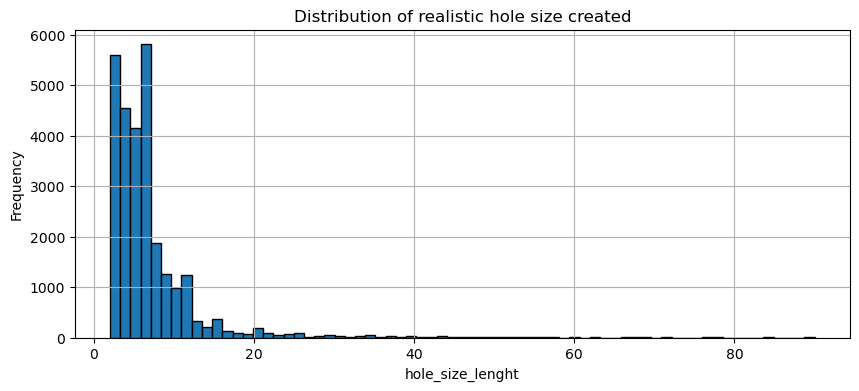

In [92]:
hole_size_1 = results_df_original['hole_size_1'].dropna().tolist()
hole_size_2 = results_df_original['hole_size_2'].dropna().tolist()
hole_size_3 = results_df_original['hole_size_3'].dropna().tolist()
hole_size_4 = results_df_original['hole_size_4'].dropna().tolist()
hole_size = hole_size_1 + hole_size_2 + hole_size_3 + hole_size_4
print('the number of holes created in total is:',len(hole_size))
# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(hole_size, bins=len(set(hole_size)), edgecolor='black')
#plt.hist(hole_size_2, bins=100, edgecolor='red')
#plt.hist(hole_size_3, bins=100, edgecolor='orange')
#plt.hist(hole_size_4, bins=100, edgecolor='blue')
plt.title('Distribution of realistic hole size created')
plt.xlabel('hole_size_lenght')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Holes distribution from real data**

In [93]:
# Retrieving the satu_lengths_prob from notebook No.1:
%store -r satu_lengths_prob

# Extract lengths and probabilities
lengths = satu_lengths_prob['lengths'].values
probabilities = satu_lengths_prob['probabilities'].values

**Creating synthetic holes in duplicated windows with uniform distribution:**

In [83]:
def find_cycles(df):
    """
    Find valid cycles in the DataFrame where a cycle starts at a min_peak and ends at the next min_peak with one max_peak in between.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the signal data. It must include 'is_min_peak' and 'is_max_peak' columns, which are boolean indicators of peaks.

    Returns:
    list: A list of tuples, where each tuple represents a valid cycle. Each tuple contains:
          - min_start: The index of the starting min_peak
          - max_peak: The index of the max_peak in between
          - min_end: The index of the ending min_peak
          - left_max_peak: The index of the max_peak before the first min_peak in the cycle (if applicable)
    """
    # Focus on the middle section of the DataFrame to avoid edge effects (rows 250-950)
    middle_section = df.iloc[250:950]
    # Identify indices where a minimum peak occurs in the middle section
    min_indices = middle_section[middle_section['is_min_peak']].index.tolist()
    # Identify indices where a maximum peak occurs in the middle section
    max_indices = middle_section[middle_section['is_max_peak']].index.tolist()
    cycles = []

    # Find the left_max_peak outside the middle section if it exists
    left_max_peak = None
    if min_indices:
        first_min = min_indices[0]
        # Look for max_peaks before the first min_peak in the middle section
        left_max_candidates = df.iloc[:250]
        left_max_candidates = left_max_candidates[left_max_candidates['is_max_peak']].index.tolist()
        if left_max_candidates:
            # Select the closest max_peak before the first min_peak in the middle section
            left_max_peak = left_max_candidates[-1]

    # Iterate over consecutive min_peaks to define cycles
    for i in range(len(min_indices) - 1):
        min_start = min_indices[i]
        min_end = min_indices[i + 1]
        # Ensure there is exactly one max_peak between two min_peaks
        max_in_cycle = [idx for idx in max_indices if min_start < idx < min_end]

        if len(max_in_cycle) == 1:
            # Valid cycle found, add it to the cycles list
            cycles.append((min_start, max_in_cycle[0], min_end, left_max_peak))
            left_max_peak = max_in_cycle[0]  # Update left_max_peak for the next cycle

    return cycles

In [85]:
def synthetic_holes_creation_uniform(training_windows_dict, min_cycle_count):
    """
    This function duplicates each window in the training_windows_dict by the number of min_cycle_count found and creates artificial "holes" in the data, which are replaced with mean values.

    Parameters:
    training_windows_dict (dict): A dictionary containing DataFrames of PPG signal data.
    min_cycle_count (int): The minimum number of cycles to be considered for creating the duplicated windows.

    Returns:
    duplicated_training_windows_dict (dict): A new dictionary containing the processed windows with artificial holes.
    results_df (df): A DataFrame containing metadata about each generated window.
    """
    duplicated_training_windows_dict = {}
    results_list = []

    # Make a deep copy of the original dictionary to ensure it remains unchanged
    training_windows_dict_copy = {key: df.copy() for key, df in training_windows_dict.items()}

    for key, df in training_windows_dict_copy.items():
        new_df = df.copy()
        cycles = find_cycles(new_df)  # Find valid cycles in the DataFrame

        for i in range(1, min_cycle_count + 1):
            if i > len(cycles):
                break  # Prevent selecting more cycles than available

            # Randomly select 'i' cycles from the available cycles
            selected_cycles = random.sample(cycles, i)
            selected_cycles_with_types = []
            for cycle in selected_cycles:
                min_start, _, min_end, _ = cycle
                # Randomly decide if the cycle should be treated as 'max' or 'min'
                cycle_type = 'max' if random.random() < 0.79 else 'min'
                selected_cycles_with_types.append((cycle, cycle_type))

            for hole_size in range(2, 101):
                # Create a new DataFrame for each hole size to ensure independent modifications
                brand_new_df = new_df.copy()

                # Prepare a dictionary to store metadata about this specific operation
                result_dict = {
                    'original_window': key,
                    'cycles_amount': i,
                    'hole_size': hole_size,
                    'Cycle_1': None, 'Type_1': None, 'hole_size_1': None, 'start_idx_1': None, 'end_idx_1': None,
                    'Cycle_2': None, 'Type_2': None, 'hole_size_2': None, 'start_idx_2': None, 'end_idx_2': None,
                    'Cycle_3': None, 'Type_3': None, 'hole_size_3': None, 'start_idx_3': None, 'end_idx_3': None,
                    'Cycle_4': None, 'Type_4': None, 'hole_size_4': None, 'start_idx_4': None, 'end_idx_4': None,
                }

                for cycle_idx, (cycle, cycle_type) in enumerate(selected_cycles_with_types, start=1):
                    min_start, max_peak, min_end, left_max_peak = cycle
                    # Determine the range of values to modify based on the cycle type
                    check_values = brand_new_df['PLETH'][min_start:min_end] if cycle_type == 'max' else brand_new_df['PLETH'][left_max_peak:max_peak]
                    if hole_size > len(check_values):
                        break  # Skip if the hole size is uniformr than the available data segment

                    if cycle_type == 'max':
                        # Sort values and select the top 'hole_size' values to modify
                        sorted_indices = np.argsort(check_values.values)
                        sorted_original_indices = check_values.index[sorted_indices]
                        if hole_size + 1 > len(sorted_original_indices):
                            break
                        top_hole_size_indices = sorted_original_indices[-hole_size:]
                        next_index = sorted_original_indices[-(hole_size + 1)]
                        next_value = check_values.loc[next_index]
                        last_value_in_top_values = check_values.loc[top_hole_size_indices[0]]
                        mean_value = np.round((next_value + last_value_in_top_values) / 2)
                        start_index = top_hole_size_indices.min()
                        end_index = top_hole_size_indices.max()
                        # Replace the selected range with the calculated mean value
                        check_values.loc[start_index:end_index+1] = mean_value

                    else:
                        # Sort values and select the bottom 'hole_size' values to modify
                        sorted_indices = np.argsort(check_values.values)
                        sorted_original_indices = check_values.index[sorted_indices]
                        if hole_size + 1 > len(sorted_original_indices):
                            break
                        bottom_hole_size_indices = sorted_original_indices[:hole_size]
                        next_index = sorted_original_indices[hole_size]
                        next_value = check_values.loc[next_index]
                        last_value_in_bottom_values = check_values.loc[bottom_hole_size_indices[-1]]
                        mean_value = np.round((next_value + last_value_in_bottom_values) / 2)
                        start_index = bottom_hole_size_indices.min()
                        end_index = bottom_hole_size_indices.max()
                        # Replace the selected range with the calculated mean value
                        check_values.loc[start_index:end_index+1] = mean_value

                    # Store metadata about the modification
                    result_dict[f'Cycle_{cycle_idx}'] = (min_start, max_peak, min_end)
                    result_dict[f'Type_{cycle_idx}'] = cycle_type
                    result_dict[f'hole_size_{cycle_idx}'] = hole_size
                    result_dict[f'start_idx_{cycle_idx}'] = start_index
                    result_dict[f'end_idx_{cycle_idx}'] = end_index

                    # Generate a unique key for the modified DataFrame
                    new_key = f"{key}_dup_num_{i}_hole_size_{hole_size}"
                    # Update the new DataFrame with the modified values
                    if cycle_type == 'max':
                        brand_new_df.loc[top_hole_size_indices, 'PLETH'] = mean_value
                    else:
                        brand_new_df.loc[bottom_hole_size_indices, 'PLETH'] = mean_value
                    duplicated_training_windows_dict[new_key] = brand_new_df

                # Add the metadata to the results list
                results_list.append(result_dict)

    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results_list)
    return duplicated_training_windows_dict, results_df

In [87]:
processed_windows_dict_uniform, results_df_uniform = synthetic_holes_creation_uniform(training_windows_dict, min_cycle_count)

the number of holes created in total is: 243248


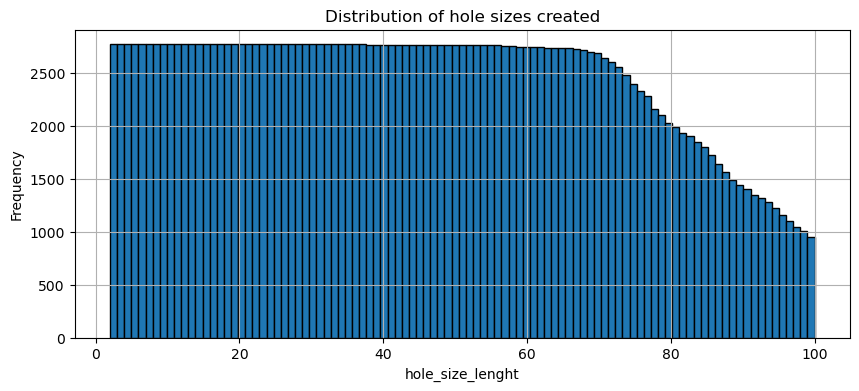

In [89]:
hole_size_1 = results_df_uniform['hole_size_1'].dropna().tolist()
hole_size_2 = results_df_uniform['hole_size_2'].dropna().tolist()
hole_size_3 = results_df_uniform['hole_size_3'].dropna().tolist()
hole_size_4 = results_df_uniform['hole_size_4'].dropna().tolist()
hole_size = hole_size_1 + hole_size_2 + hole_size_3 + hole_size_4
print('the number of holes created in total is:',len(hole_size))

# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(hole_size, bins=len(set(hole_size)), edgecolor='black')
#plt.hist(hole_size_2, bins=100, edgecolor='red')
#plt.hist(hole_size_3, bins=100, edgecolor='orange')
#plt.hist(hole_size_4, bins=100, edgecolor='blue')
plt.title('Distribution of hole sizes created')
plt.xlabel('hole_size_lenght')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**The goal of this code is to simulate real-world scenarios where parts of a PPG signal are missing or corrupted.**

In [94]:
def set_flat_parts_to_nan(windows_dict, results_df_uniform):
    """
    This function modifies the given windows by setting specific parts of the 'PLETH' signal to NaN
    based on the cycle indices provided in the results DataFrame.

    Parameters:
    windows_dict (dict): A dictionary containing windows dataframes.
    results_df_uniform (DataFrame): A DataFrame containing information about the cycles and hole sizes.

    Returns:
    new_dict (dict): A new dictionary with modified windows where specific parts of the 'PLETH' signal have been set to NaN.
    """

    # Make a deep copy of the original dictionary to ensure it remains unchanged
    windows_dict_copy = {key: df.copy() for key, df in windows_dict.items()}

    # Initialize a new dictionary to store the modified dataframes
    new_dict = {}

    # Iterate through each row in the results DataFrame
    for index, row in results_df_uniform.iterrows():
        original_key = row['original_window']  # Retrieve the original key from the row
        cycles_amount = row['cycles_amount']  # Get the number of cycles from the row
        hole_size = row['hole_size']  # Get the hole size from the row

        # Construct the new key using the original key, number of cycles, and hole size
        new_key = f"{original_key}_dup_num_{cycles_amount}_hole_size_{hole_size}"

        # Debugging: Print the new key and existing keys
        if new_key not in windows_dict_copy:
            continue  # If the new key is not found in the dictionary, skip this iteration

        # Create a copy of the dataframe associated with the new key
        new_df = windows_dict_copy[new_key].copy()

        # Loop over the number of cycles (up to 4 cycles)
        for cycle_num in range(1, cycles_amount + 1):
            start_idx_col = f'start_idx_{cycle_num}'  # Column name for the start index of the cycle
            end_idx_col = f'end_idx_{cycle_num}'  # Column name for the end index of the cycle

            # Check if both start and end indices are not NaN
            if pd.notna(row[start_idx_col]) and pd.notna(row[end_idx_col]):
                start_idx = int(row[start_idx_col])  # Convert the start index to an integer
                end_idx = int(row[end_idx_col])  # Convert the end index to an integer

                # Set the 'PLETH' values within the cycle range to NaN
                new_df.loc[start_idx:end_idx, 'PLETH'] = np.nan

        # Store the modified dataframe in the new dictionary using the new key
        new_dict[new_key] = new_df

    # Return the new dictionary containing the modified windows
    return new_dict

In [95]:
processed_windows_dict_uniform_with_nan = set_flat_parts_to_nan(processed_windows_dict_uniform, results_df_uniform)
processed_windows_dict_original_with_nan = set_flat_parts_to_nan(processed_windows_dict_original, results_df_original)

**Evaluation plot of a synthetic holes:**

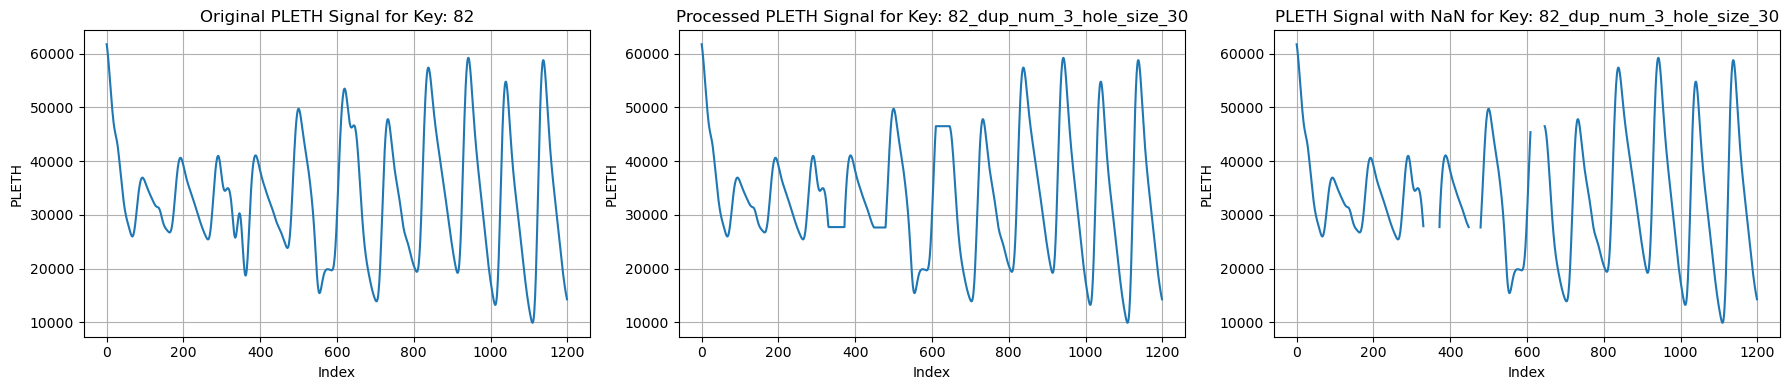

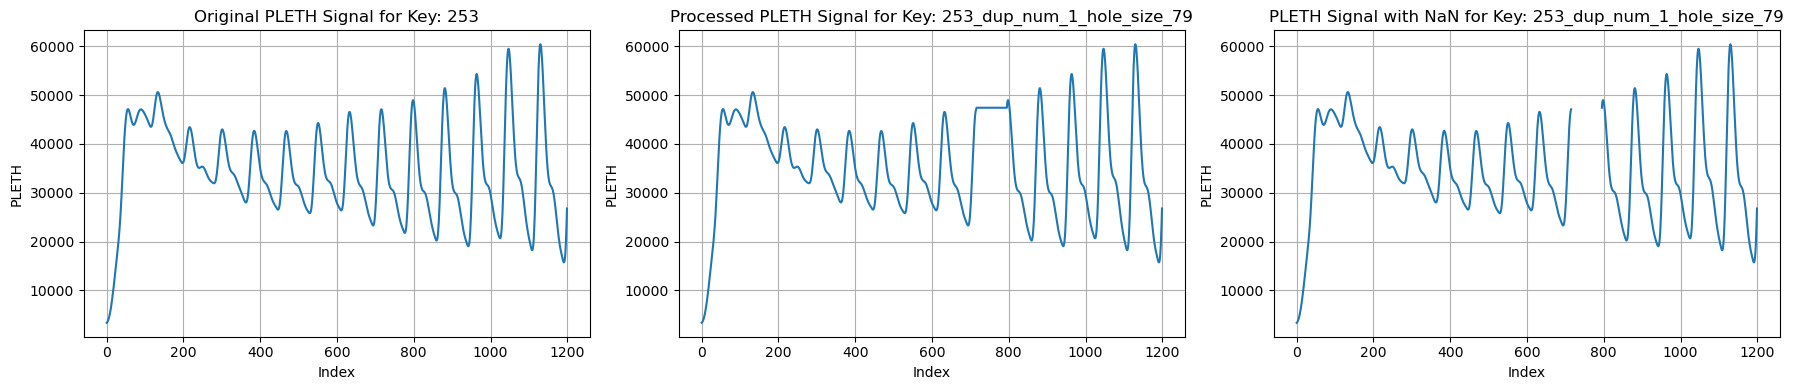

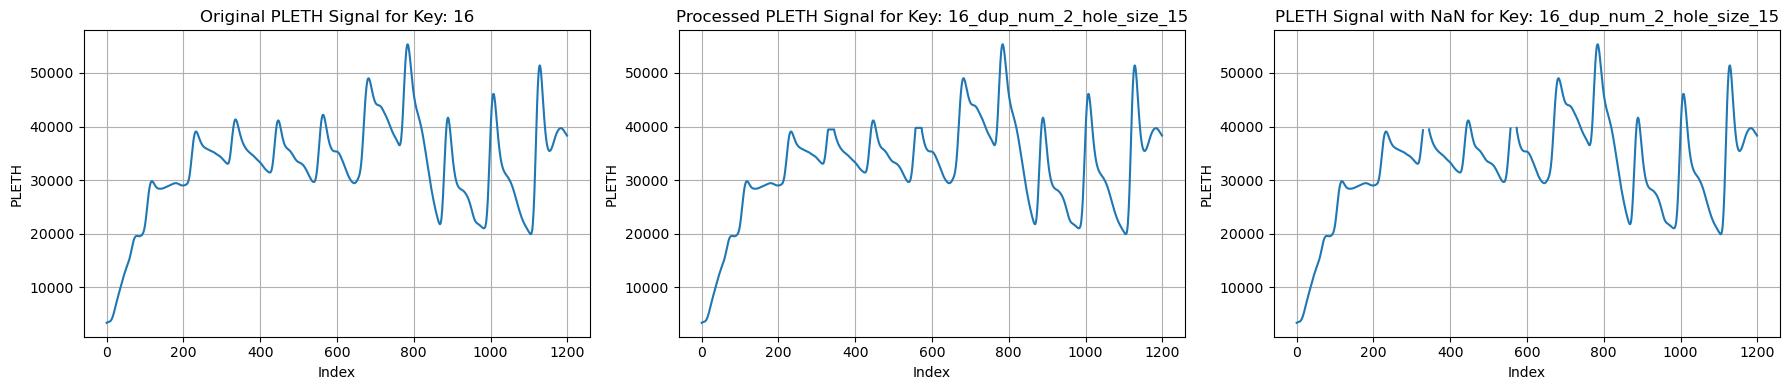

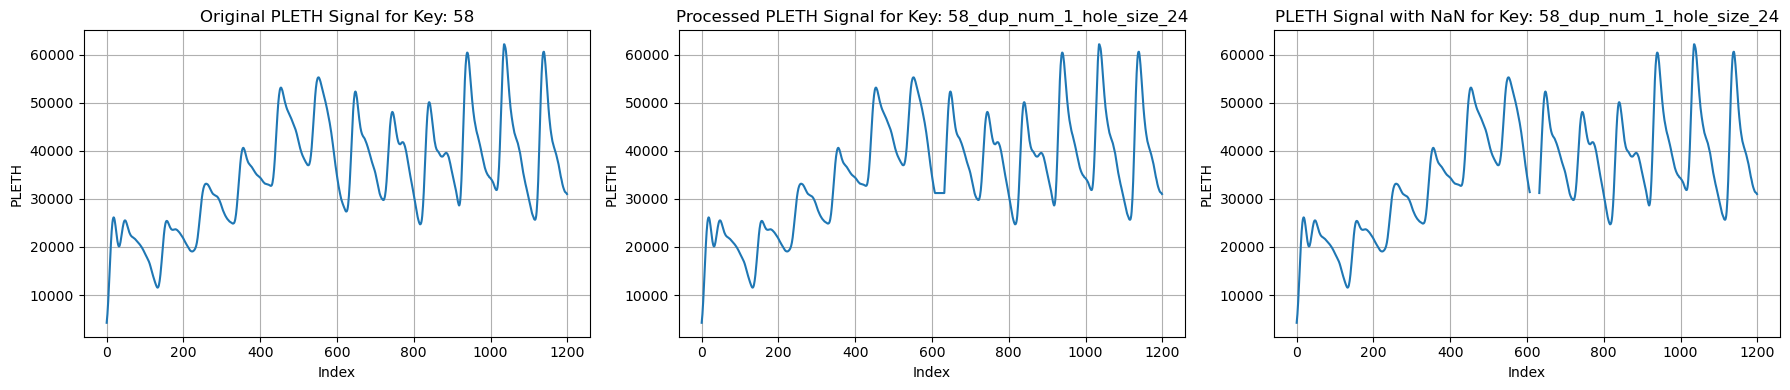

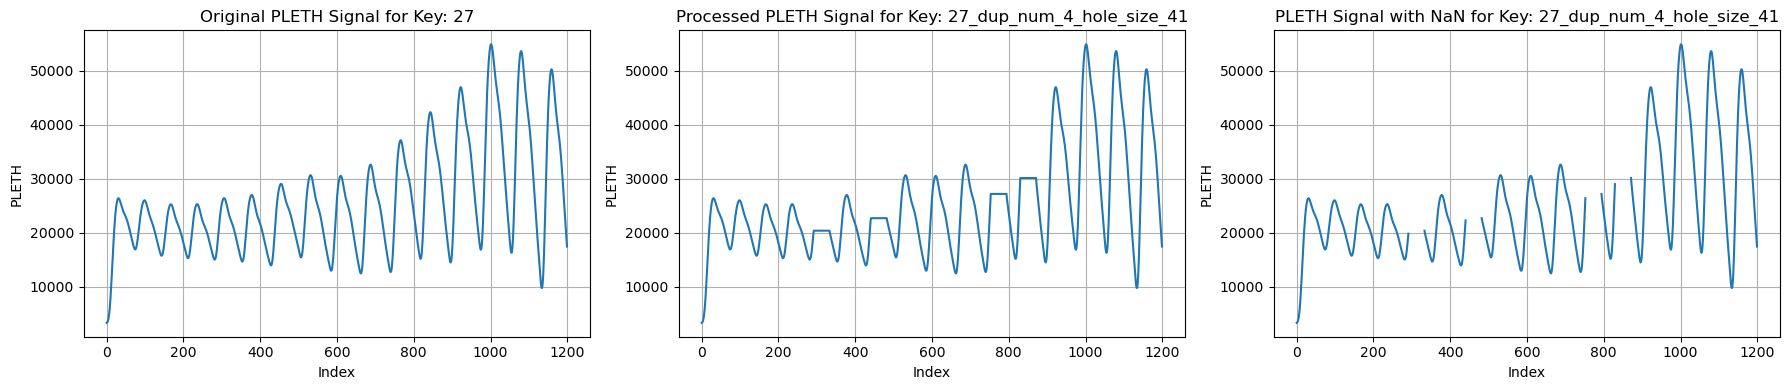

In [96]:
# Randomly select 5 keys from the processed dictionary
random_keys = random.sample(list(processed_windows_dict_uniform_with_nan.keys()), 5)

# Iterate over the 5 selected keys
for key in random_keys:
    # Extract the original key from the composite key format
    original_key = int(key.split('_')[0])  # Assuming the original key is the first part and is an integer

    # Create a figure with 3 subplots (1 row, 3 columns)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    # Plot the 'PLETH' signal from training_windows_dict
    if original_key in training_windows_dict:
        axes[0].plot(training_windows_dict[original_key]['PLETH'])
        axes[0].set_title(f'Original PLETH Signal for Key: {original_key}')
        axes[0].set_xlabel('Index')
        axes[0].set_ylabel('PLETH')
        axes[0].grid(True)
    else:
        axes[0].set_title(f'Key: {original_key} not found in training_windows_dict')

    # Plot the 'PLETH' signal from processed_windows_dict_uniform
    axes[1].plot(processed_windows_dict_uniform[key]['PLETH'])
    axes[1].set_title(f'Processed PLETH Signal for Key: {key}')
    axes[1].set_xlabel('Index')
    axes[1].set_ylabel('PLETH')
    axes[1].grid(True)

    # Plot the 'PLETH' signal from training_windows_dict_with_nan
    if key in processed_windows_dict_uniform_with_nan:
        axes[2].plot(processed_windows_dict_uniform_with_nan[key]['PLETH'])
        axes[2].set_title(f'PLETH Signal with NaN for Key: {key}')
        axes[2].set_xlabel('Index')
        axes[2].set_ylabel('PLETH')
        axes[2].grid(True)
    else:
        axes[2].set_title(f'Key: {key} not found in processed_windows_dict_uniform_with_nan')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

**First interpulation model - Cubic Spline**

In [97]:
def interpolate_nans(window_with_nan, complete_window):
    """
    Interpolate NaN values in a window using cubic spline interpolation.

    Parameters:
    - window_with_nan (numpy array): The array containing NaN values where interpolation needs to be performed.
    - complete_window (numpy array): The original complete array (without NaN values) used for reference.

    Returns:
    - complete_window_with_interpolation (numpy array): The array with NaN values filled in using cubic spline interpolation.
    """
    # Indices of the valid (non-NaN) points
    valid_idx = np.where(~np.isnan(window_with_nan))[0]

    # Indices of the NaN points that need interpolation
    nan_idx = np.where(np.isnan(window_with_nan))[0]

    # Values of the valid points (non-NaN values) used for fitting the spline
    valid_values = window_with_nan[valid_idx]

    # Fit the cubic spline model to the valid points
    cs = CubicSpline(valid_idx, valid_values)

    # Interpolate the NaN points using the fitted cubic spline model
    interpolated_values = cs(nan_idx)

    # Create a new array by copying the original window and filling in the interpolated values
    complete_window_with_interpolation = window_with_nan.copy()
    complete_window_with_interpolation[nan_idx] = interpolated_values

    return complete_window_with_interpolation

In [98]:
def impute_nans_with_spline(new_training_windows_dict, training_windows_dict):
    """
    Impute NaN values in a dictionary of PLETH windows using cubic spline interpolation.

    Parameters:
    - new_training_windows_dict (dict): Dictionary where each key corresponds to a window with NaN values in the 'PLETH' column.
    - training_windows_dict (dict): Dictionary of original complete windows without NaN values.

    Returns:
    - imputed_dict (dict): A dictionary where the NaN values in the 'PLETH' column of each window have been imputed using cubic spline interpolation.
    """
    imputed_dict = {}  # Initialize an empty dictionary to store the imputed windows

    for key in new_training_windows_dict.keys():
        # Extract the PLETH values with NaNs from the current window
        window_with_nan = new_training_windows_dict[key]['PLETH'].values

        # Extract the corresponding complete PLETH values from the original window
        complete_window = training_windows_dict[int(key.split('_')[0])]['PLETH'].values

        # Impute the NaN values using cubic spline interpolation
        imputed_window = interpolate_nans(window_with_nan, complete_window)

        # Create a copy of the current DataFrame to modify
        imputed_df = new_training_windows_dict[key].copy()

        # Replace the 'PLETH' column with the imputed values
        imputed_df['PLETH'] = imputed_window

        # Store the imputed DataFrame in the dictionary
        imputed_dict[key] = imputed_df

    return imputed_dict

In [99]:
cubic_imputed_windows_dict_uniform = impute_nans_with_spline(processed_windows_dict_uniform_with_nan, training_windows_dict)
cubic_imputed_windows_dict_original = impute_nans_with_spline(processed_windows_dict_original_with_nan, training_windows_dict)

In [100]:
def plot_original_vs_imputed(original_dict, nan_dict, imputed_dict, key):
    """
    Plots the original, NaN-containing, and imputed PLETH signals for a given key.

    Parameters:
    - original_dict (dict): Dictionary containing the original PLETH signals without NaN values.
    - nan_dict (dict): Dictionary containing PLETH signals with NaN values.
    - imputed_dict (dict): Dictionary containing PLETH signals after NaN values have been imputed.
    - key (str): The key corresponding to the specific window to be plotted.

    Returns:
    - None: The function displays the plot comparing the original, NaN-containing, and imputed signals.
    """
    # Extract the relevant portion of the original, NaN-containing, and imputed signals
    original_signal = original_dict[int(key.split('_')[0])]['PLETH']
    nan_signal = nan_dict[key]['PLETH']
    imputed_signal = imputed_dict[key]['PLETH']

    # Create a mask to identify where NaN values are located in the NaN-containing signal
    nan_mask = np.isnan(nan_signal)

    # Prepare an array to plot the imputed signal only where NaNs were in nan_signal
    imputed_signal_only_nan = np.full_like(nan_signal, np.nan)
    imputed_signal_only_nan[nan_mask] = imputed_signal[:len(nan_signal)][nan_mask]

    plt.figure(figsize=(10, 4))
    plt.plot(original_signal, label='Original Signal', color='black')  # Plot the original signal
    plt.plot(nan_signal, label='Signal with NaNs', linestyle='--')  # Plot the signal with NaNs

    # Plot each segment of the imputed signal separately where NaNs were present
    start = None
    imputed_signal_plotted = False  # Flag to control adding the label to the legend

    for i in range(len(imputed_signal_only_nan)):
        if np.isnan(imputed_signal_only_nan[i]):
            if start is not None:
                if not imputed_signal_plotted:
                    plt.plot(range(start, i), imputed_signal_only_nan[start:i], label='Imputed Signal', linestyle='--', color='red')
                    imputed_signal_plotted = True
                else:
                    plt.plot(range(start, i), imputed_signal_only_nan[start:i], linestyle='--', color='red')
                start = None
        else:
            if start is None:
                start = i
    if start is not None:
        if not imputed_signal_plotted:
            plt.plot(range(start, len(imputed_signal_only_nan)), imputed_signal_only_nan[start:], label='Imputed Signal', linestyle='--', color='red')
        else:
            plt.plot(range(start, len(imputed_signal_only_nan)), imputed_signal_only_nan[start:], linestyle='--', color='red')

    # Add horizontal dashed lines at indexes 250 and 950
    plt.axvline(x=250, color='orange', linestyle='--')
    plt.axvline(x=950, color='orange', linestyle='--')

    plt.title(f"Original vs NaN vs Imputed Signal for {key}")
    plt.xlabel('Index')
    plt.ylabel('PLETH')
    plt.legend()
    plt.show()


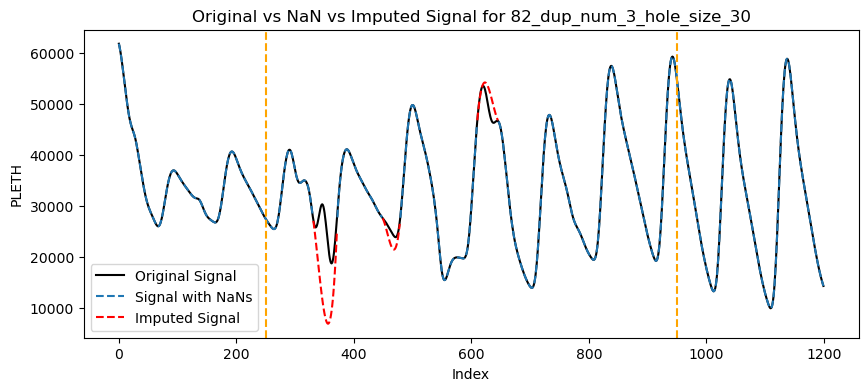

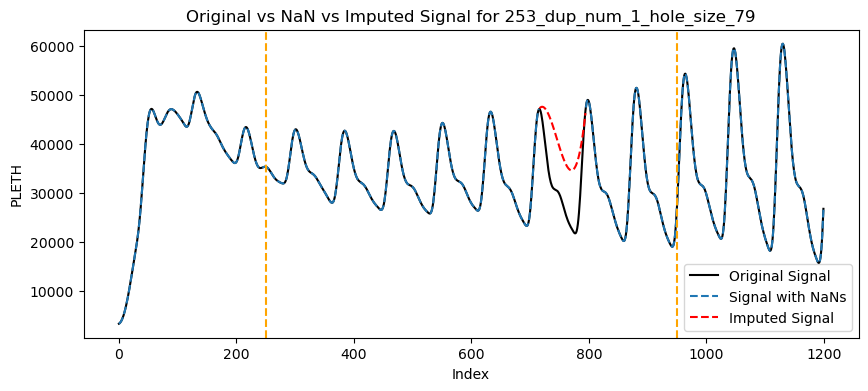

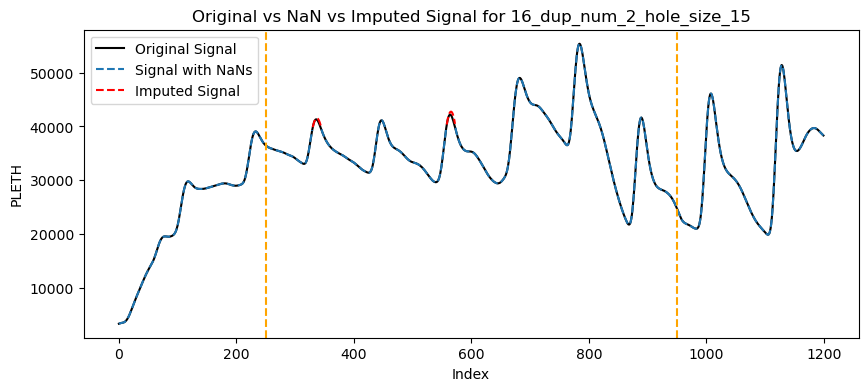

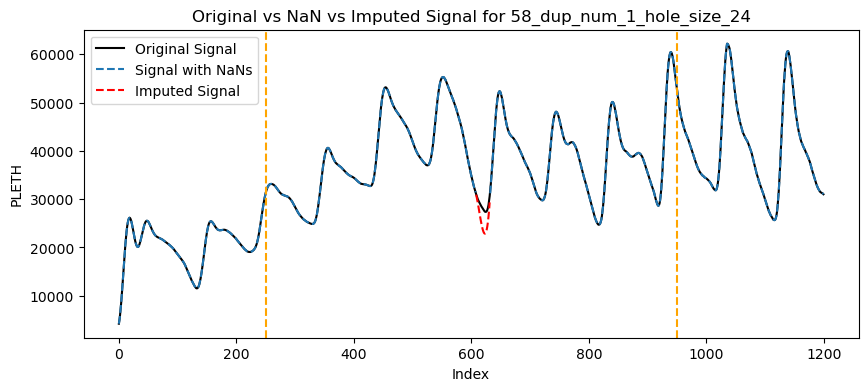

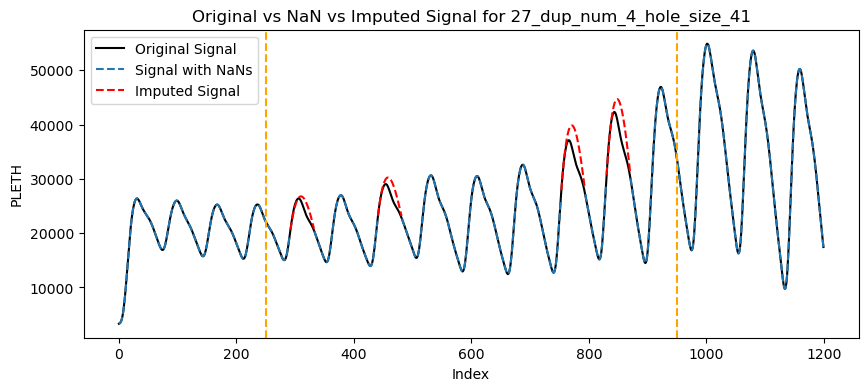

In [101]:
# Plot the original, NaN-containing, and imputed signals for the 5 random keys
for key in random_keys:
    plot_original_vs_imputed(proper_windows_dict, processed_windows_dict_uniform_with_nan, cubic_imputed_windows_dict_uniform, key)

**Second interpulation model - B-Spline**

In [102]:
def interpolate_nans_b_spline(window_with_nan):
    """
    Interpolates the NaN values in a PLETH signal using a B-spline interpolation.

    Parameters:
    - window_with_nan (numpy array): The array containing the PLETH signal with NaN values.

    Returns:
    - complete_window_with_interpolation (numpy array): The array with NaN values filled in using B-spline interpolation.
    """
    # Indices of the valid (non-NaN) points
    valid_idx = np.where(~np.isnan(window_with_nan))[0]  # Get indices where values are not NaN
    nan_idx = np.where(np.isnan(window_with_nan))[0]  # Get indices where values are NaN

    # Values of the valid points
    valid_values = window_with_nan[valid_idx]  # Extract the non-NaN values

    # Fit the B-spline model to the valid points
    tck = splrep(valid_idx, valid_values, k=2)  # Compute the B-spline representation

    # Interpolate the NaN points
    interpolated_values = splev(nan_idx, tck)  # Use the B-spline to evaluate the NaN points

    # Create the complete window by filling in the interpolated values
    complete_window_with_interpolation = window_with_nan.copy()  # Make a copy of the original array
    complete_window_with_interpolation[nan_idx] = interpolated_values  # Fill in the NaN values with interpolated values

    return complete_window_with_interpolation

In [103]:
def impute_nans_with_b_spline(new_training_windows_dict, training_windows_dict):
    """
    Applies B-spline interpolation to fill NaN values in the PLETH signals across multiple windows.

    Parameters:
    - new_training_windows_dict (dict): Dictionary containing the PLETH signals with NaN values.
    - training_windows_dict (dict): Dictionary containing the original, complete PLETH signals.

    Returns:
    - imputed_dict (dict): Dictionary with PLETH signals where NaN values have been imputed using B-spline interpolation.
    """
    imputed_dict = {}

    for key in new_training_windows_dict.keys():
        window_with_nan = new_training_windows_dict[key]['PLETH'].values  # Get the PLETH signal with NaNs
        imputed_window = interpolate_nans_b_spline(window_with_nan)  # Apply B-spline interpolation
        imputed_df = new_training_windows_dict[key].copy()  # Copy the original DataFrame
        imputed_df['PLETH'] = imputed_window  # Replace the PLETH column with the imputed values
        imputed_dict[key] = imputed_df  # Store the imputed DataFrame in the dictionary

    return imputed_dict

In [104]:
b_spline_imputed_windows_dict_uniform = impute_nans_with_b_spline(processed_windows_dict_uniform_with_nan, training_windows_dict)
b_spline_imputed_windows_dict_original = impute_nans_with_b_spline(processed_windows_dict_original_with_nan, training_windows_dict)

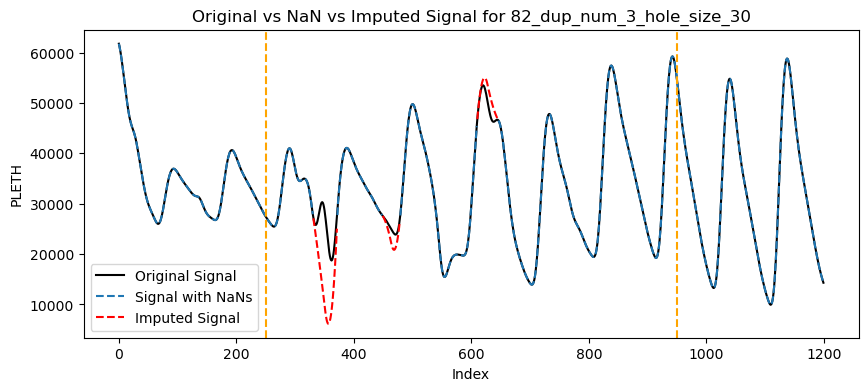

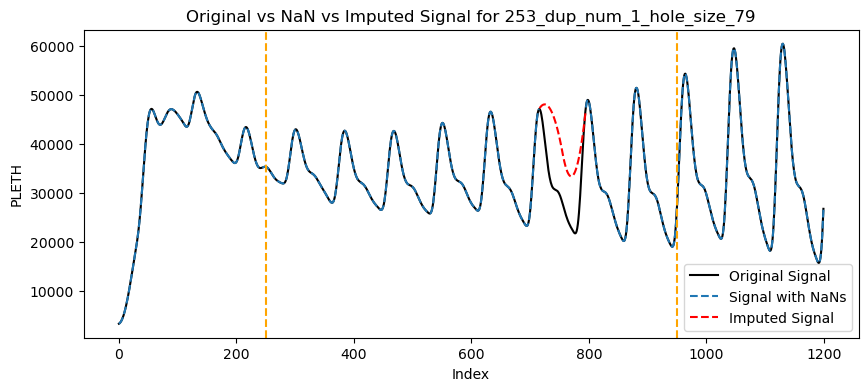

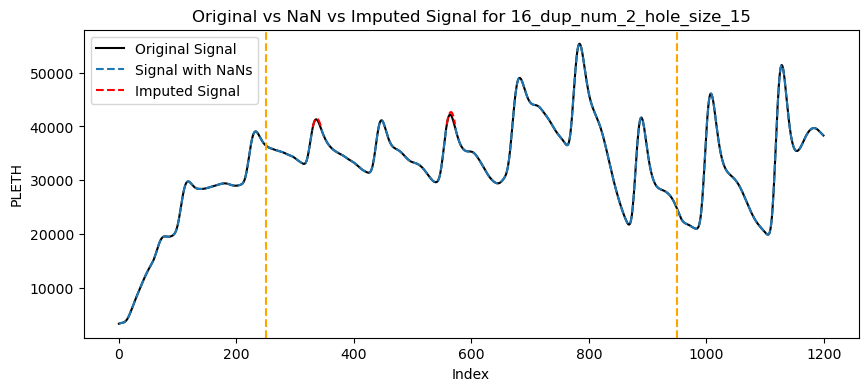

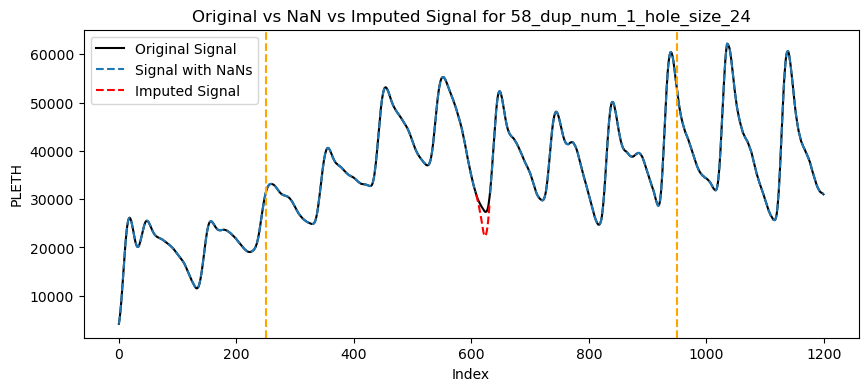

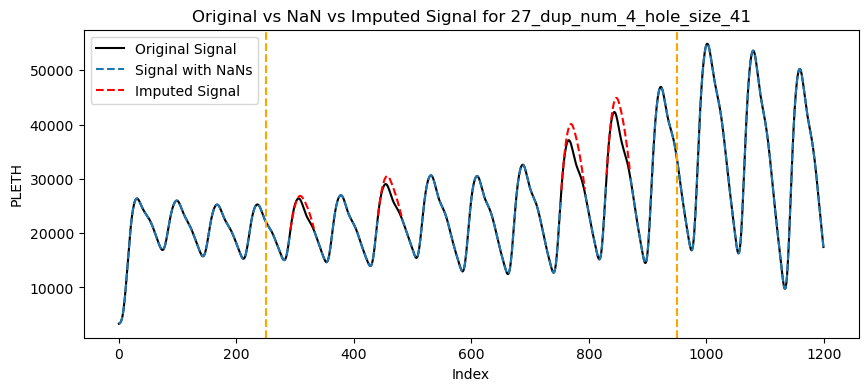

In [105]:
# Plot the original, NaN-containing, and imputed signals for the 5 random keys
for key in random_keys:
    plot_original_vs_imputed(proper_windows_dict, processed_windows_dict_uniform_with_nan, b_spline_imputed_windows_dict_uniform, key)

**Calculate RMSE and Imputation score**

In [106]:
def calculate_imputetion_score_per_cycle(results_df, original_dict, processed_dict, imputed_dict, method):
    """
    Calculates the imputation score for each cycle in the PLETH signal, comparing the imputed signal to the original signal.

    Parameters:
    - results_df (DataFrame): DataFrame containing information about the cycles, including start and end indices.
    - original_dict (dict): Dictionary containing the original, unaltered PLETH signals.
    - processed_dict (dict): Dictionary containing the PLETH signals with artificially created flat regions (holes).
    - imputed_dict (dict): Dictionary containing the PLETH signals where NaN values have been imputed using a specific method.
    - method (str): String indicating the imputation method used ('cubic' or 'b_spline').

    Returns:
    - results_df (DataFrame): The updated DataFrame with imputation scores and RMSE values for each cycle.

    """
    # Map the method name to the appropriate column suffix
    method_map = {
        'cubic': 'cubic',
        'b_spline': 'bspline'
    }

    for index, row in results_df.iterrows():
        # Extract the original key from the 'original_window' column in the results DataFrame
        original_key = int(row['original_window'])

        for cycle_num in range(1, 5):  # Loop through up to 4 cycles (as the code is designed for up to 4 cycles)
            # Identify the start and end index columns and the corresponding score/RMSE columns
            start_idx_col = f'start_idx_{cycle_num}'
            end_idx_col = f'end_idx_{cycle_num}'
            imputetion_score_col = f"imputetion_score_{method_map[method]}_{cycle_num}"
            imputed_rmse_col = f"imputed_{method_map[method]}_rmse_{cycle_num}"
            flat_rmse_col = f"flat_{method_map[method]}_rmse_{cycle_num}"

            # Check if the start and end indices are not NaN
            if pd.notna(row[start_idx_col]) and pd.notna(row[end_idx_col]):
                start_idx = int(row[start_idx_col])  # Get the start index of the cycle
                end_idx = int(row[end_idx_col])  # Get the end index of the cycle
                indices = list(range(start_idx, end_idx + 1))  # Create a list of indices for this cycle

                # Extract the signals for the collected indices
                original_signal = original_dict[original_key].iloc[indices]['PLETH'].values  # Extract the original PLETH signal
                flat_signal = processed_dict[f"{original_key}_dup_num_{row['cycles_amount']}_hole_size_{row['hole_size']}"].iloc[indices]['PLETH'].values  # Extract the flat (processed) signal
                imputed_signal = imputed_dict[f"{original_key}_dup_num_{row['cycles_amount']}_hole_size_{row['hole_size']}"].iloc[indices]['PLETH'].values  # Extract the imputed signal

                # Calculate RMSE (Root Mean Square Error) values
                imputed_RMSE = np.sqrt(mean_squared_error(original_signal, imputed_signal))  # Calculate RMSE between the original and imputed signals
                flat_RMSE = np.sqrt(mean_squared_error(original_signal, flat_signal))  # Calculate RMSE between the original and flat signals

                # Calculate imputation score: the closer the imputed RMSE is to the flat RMSE, the lower the score
                imputetion_score = 1 - (imputed_RMSE / flat_RMSE) if flat_RMSE != 0 else np.nan  # Avoid division by zero

                # Store the calculated RMSE and imputation score in the results DataFrame
                results_df.at[index, imputed_rmse_col] = imputed_RMSE
                results_df.at[index, flat_rmse_col] = flat_RMSE
                results_df.at[index, imputetion_score_col] = imputetion_score

    return results_df  # Return the updated DataFrame


In [107]:
#calculations for uniform distribution holes (cubic and b_spline):
results_df_uniform = calculate_imputetion_score_per_cycle(results_df_uniform, training_windows_dict, processed_windows_dict_uniform, cubic_imputed_windows_dict_uniform, 'cubic')
results_df_uniform = calculate_imputetion_score_per_cycle(results_df_uniform, training_windows_dict, processed_windows_dict_uniform, b_spline_imputed_windows_dict_uniform, 'b_spline')

#calculations for original distribution holes (cubic and b_spline):
results_df_original = calculate_imputetion_score_per_cycle(results_df_original, training_windows_dict, processed_windows_dict_original, cubic_imputed_windows_dict_original, 'cubic')
results_df_original = calculate_imputetion_score_per_cycle(results_df_original, training_windows_dict, processed_windows_dict_original, b_spline_imputed_windows_dict_original, 'b_spline')

**Calculating and Aggregating Imputation Scores for Cubic Spline and B-Spline Interpolation Methods Across Different Hole Sizes**

In [108]:
# Create empty lists to store average, median, std, min, and max imputetion_score values
average_imputetion_score_cubic = []
median_imputetion_score_cubic = []  # List to store median values for cubic
std_dev_imputetion_score_cubic = []
min_imputetion_score_cubic = []
perc_pos_imputetion_score_cubic = []

average_imputetion_score_bspline = []
median_imputetion_score_bspline = []  # List to store median values for B-spline
std_dev_imputetion_score_bspline = []
min_imputetion_score_bspline = []
perc_pos_imputetion_score_bspline = []

# Iterate over each hole_size_value in hole_size_values_set
for hole_size in range(2, 101):
    imputetion_score_cubic_values = []
    imputetion_score_bspline_values = []

    # Collect all corresponding imputetion_score_cubic and imputetion_score_bspline values:
    for i in range(1, 5):
        imputetion_score_cubic_values.extend(results_df_uniform[results_df_uniform[f'hole_size_{i}'] == hole_size][f'imputetion_score_cubic_{i}'].dropna().tolist())
        imputetion_score_bspline_values.extend(results_df_uniform[results_df_uniform[f'hole_size_{i}'] == hole_size][f'imputetion_score_bspline_{i}'].dropna().tolist())

    # Calculate the statistics for imputetion_score_cubic
    if imputetion_score_cubic_values:
        avg_imputetion_score_cubic = np.mean(imputetion_score_cubic_values)
        median_imputetion_score_cubic_value = np.median(imputetion_score_cubic_values)
        std_dev_imputetion_score_cubic_value = np.std(imputetion_score_cubic_values)
        min_imputetion_score_cubic_value = np.min(imputetion_score_cubic_values)
        perc_pos_imputetion_score_cubic_value = (np.sum(np.array(imputetion_score_cubic_values) > 0) / len(imputetion_score_cubic_values)) * 100
    else:
        avg_imputetion_score_cubic = median_imputetion_score_cubic_value = std_dev_imputetion_score_cubic_value = min_imputetion_score_cubic_value = perc_pos_imputetion_score_cubic_value = np.nan

    # Calculate the statistics for imputetion_score_bspline
    if imputetion_score_bspline_values:
        avg_imputetion_score_bspline = np.mean(imputetion_score_bspline_values)
        median_imputetion_score_bspline_value = np.median(imputetion_score_bspline_values)
        std_dev_imputetion_score_bspline_value = np.std(imputetion_score_bspline_values)
        min_imputetion_score_bspline_value = np.min(imputetion_score_bspline_values)
        perc_pos_imputetion_score_bspline_value = (np.sum(np.array(imputetion_score_bspline_values) > 0) / len(imputetion_score_bspline_values)) * 100
    else:
        avg_imputetion_score_bspline = median_imputetion_score_bspline_value = std_dev_imputetion_score_bspline_value = min_imputetion_score_bspline_value = perc_pos_imputetion_score_bspline_value = np.nan

    # Append to the lists
    average_imputetion_score_cubic.append(avg_imputetion_score_cubic)
    median_imputetion_score_cubic.append(median_imputetion_score_cubic_value)
    std_dev_imputetion_score_cubic.append(std_dev_imputetion_score_cubic_value)
    min_imputetion_score_cubic.append(min_imputetion_score_cubic_value)
    perc_pos_imputetion_score_cubic.append(perc_pos_imputetion_score_cubic_value)

    average_imputetion_score_bspline.append(avg_imputetion_score_bspline)
    median_imputetion_score_bspline.append(median_imputetion_score_bspline_value)
    std_dev_imputetion_score_bspline.append(std_dev_imputetion_score_bspline_value)
    min_imputetion_score_bspline.append(min_imputetion_score_bspline_value)
    perc_pos_imputetion_score_bspline.append(perc_pos_imputetion_score_bspline_value)

hole_size_values = np.arange(2, 101)

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'hole_size': hole_size_values,
    'average_imputetion_score_cubic': average_imputetion_score_cubic,
    'median_imputetion_score_cubic': median_imputetion_score_cubic,
    'std_imputetion_score_cubic': std_dev_imputetion_score_cubic,
    'min_imputetion_score_cubic': min_imputetion_score_cubic,
    'perc_pos_imputetion_score_cubic': perc_pos_imputetion_score_cubic,
    'average_imputetion_score_bspline': average_imputetion_score_bspline,
    'median_imputetion_score_bspline': median_imputetion_score_bspline,
    'std_imputetion_score_bspline': std_dev_imputetion_score_bspline,
    'min_imputetion_score_bspline': min_imputetion_score_bspline,
    'perc_pos_imputetion_score_bspline': perc_pos_imputetion_score_bspline
})


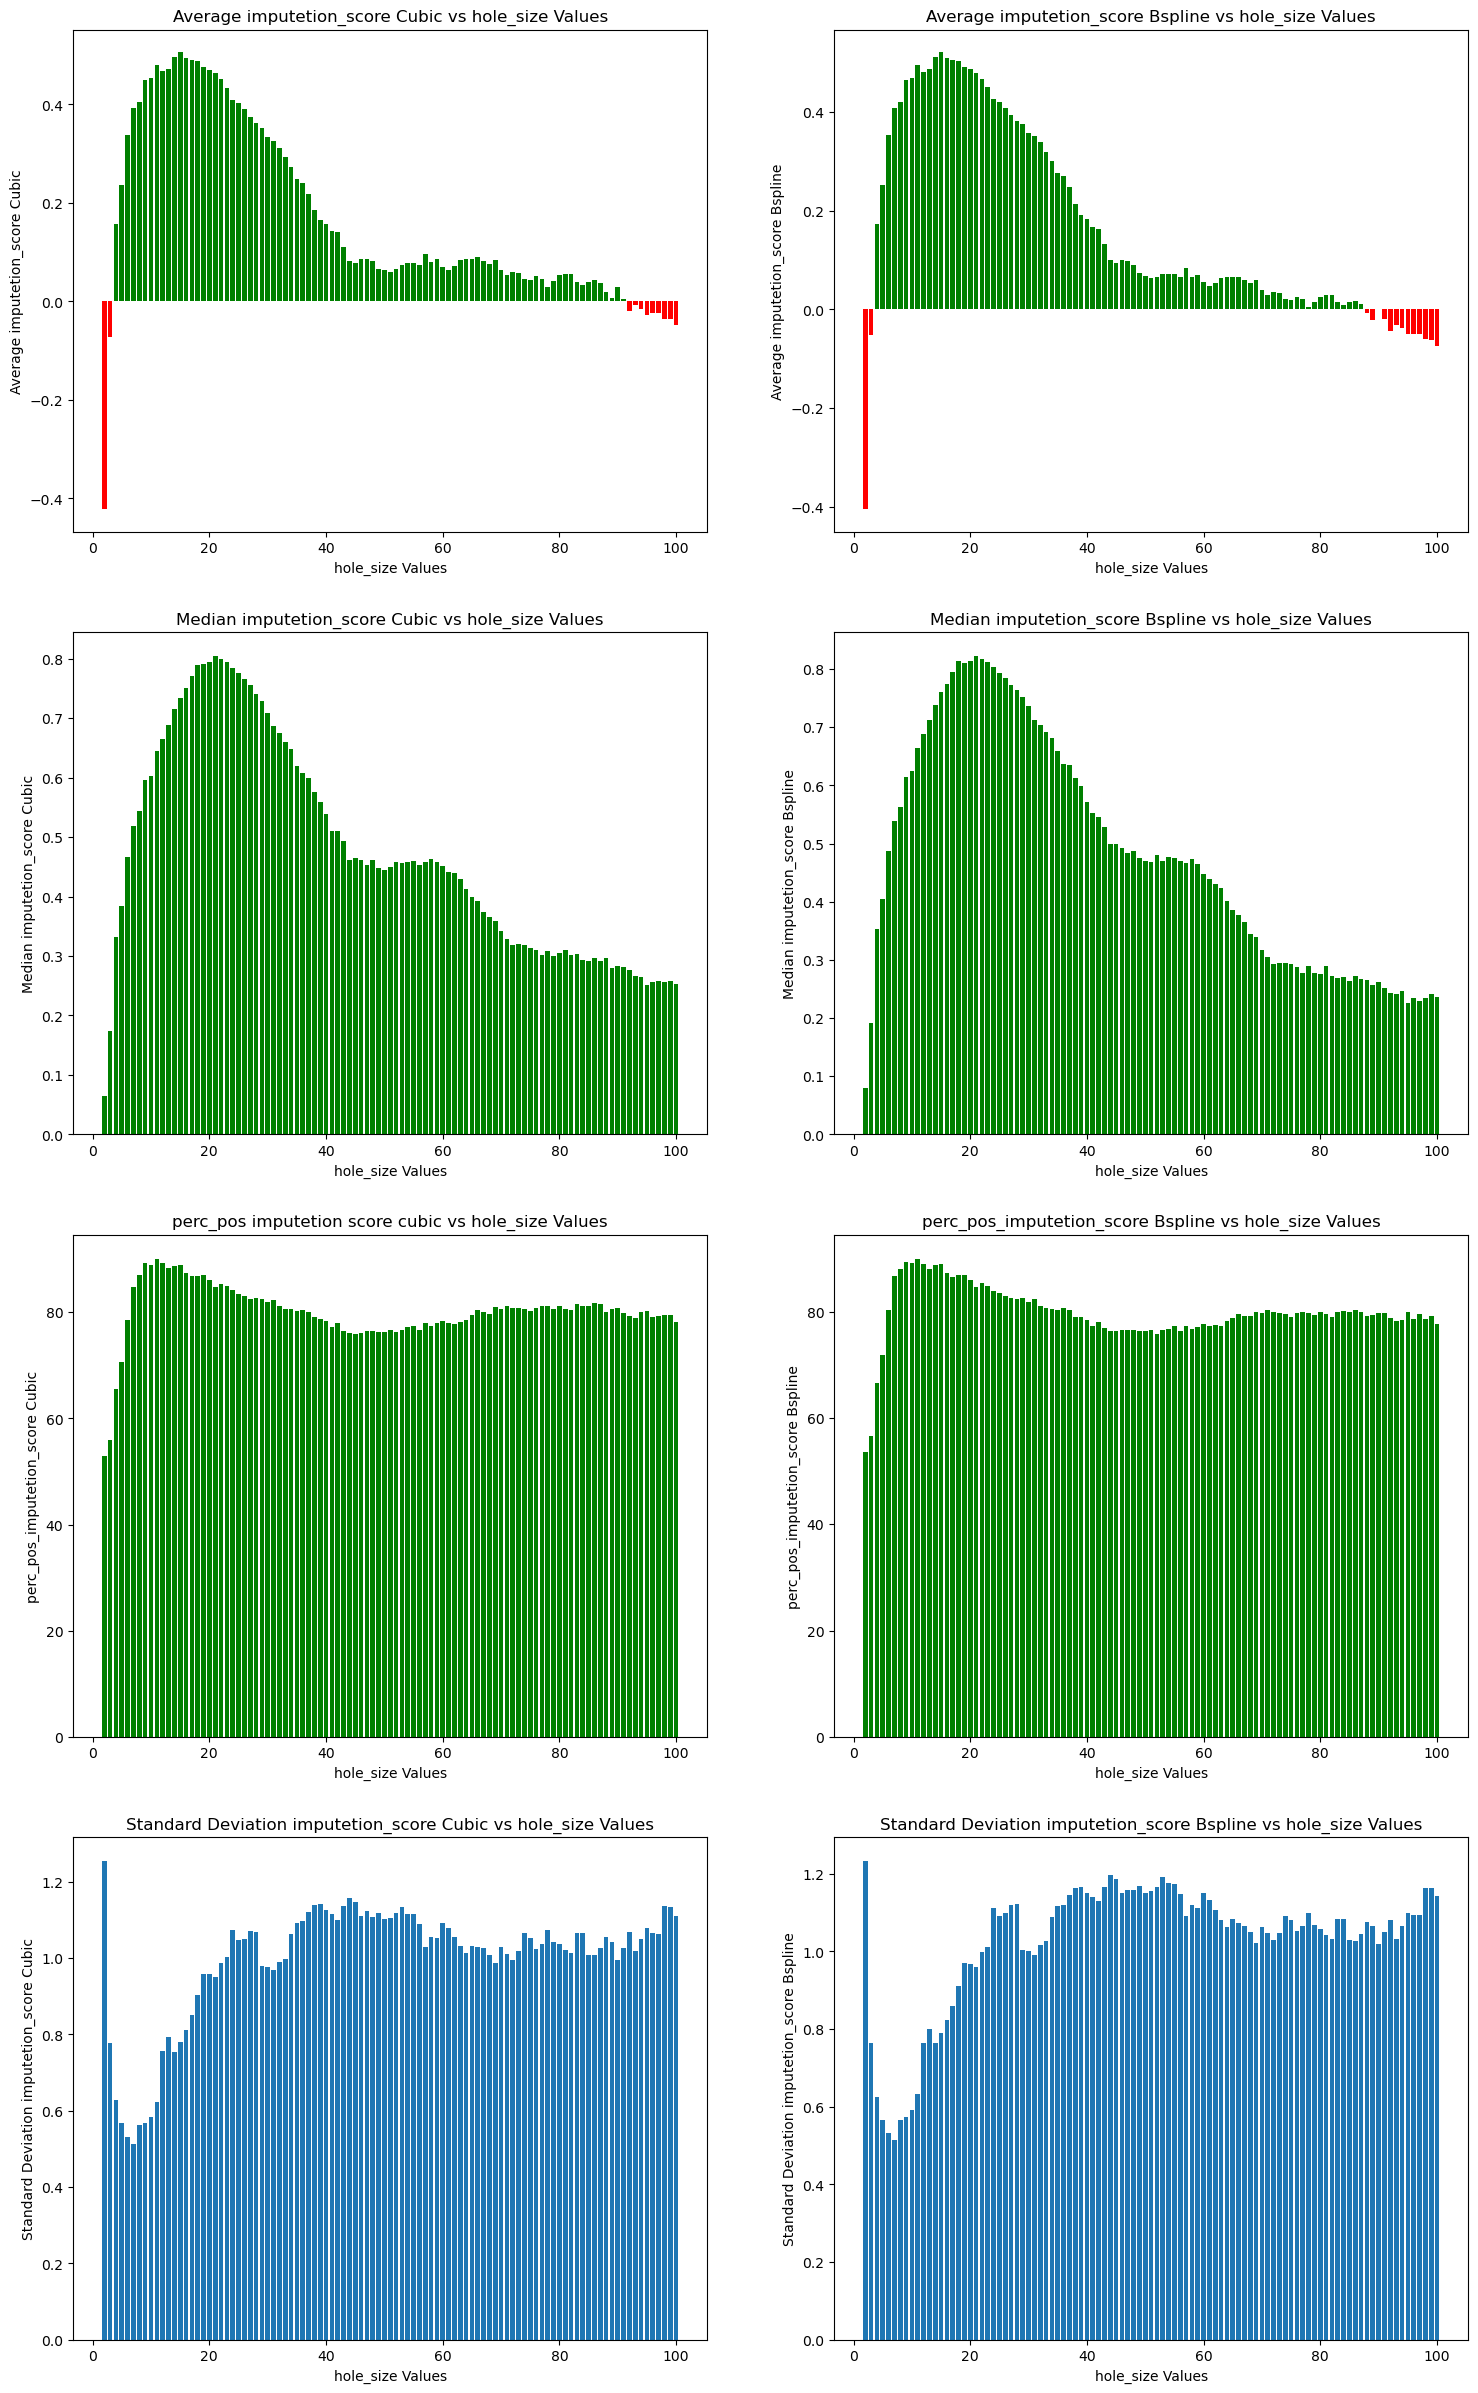

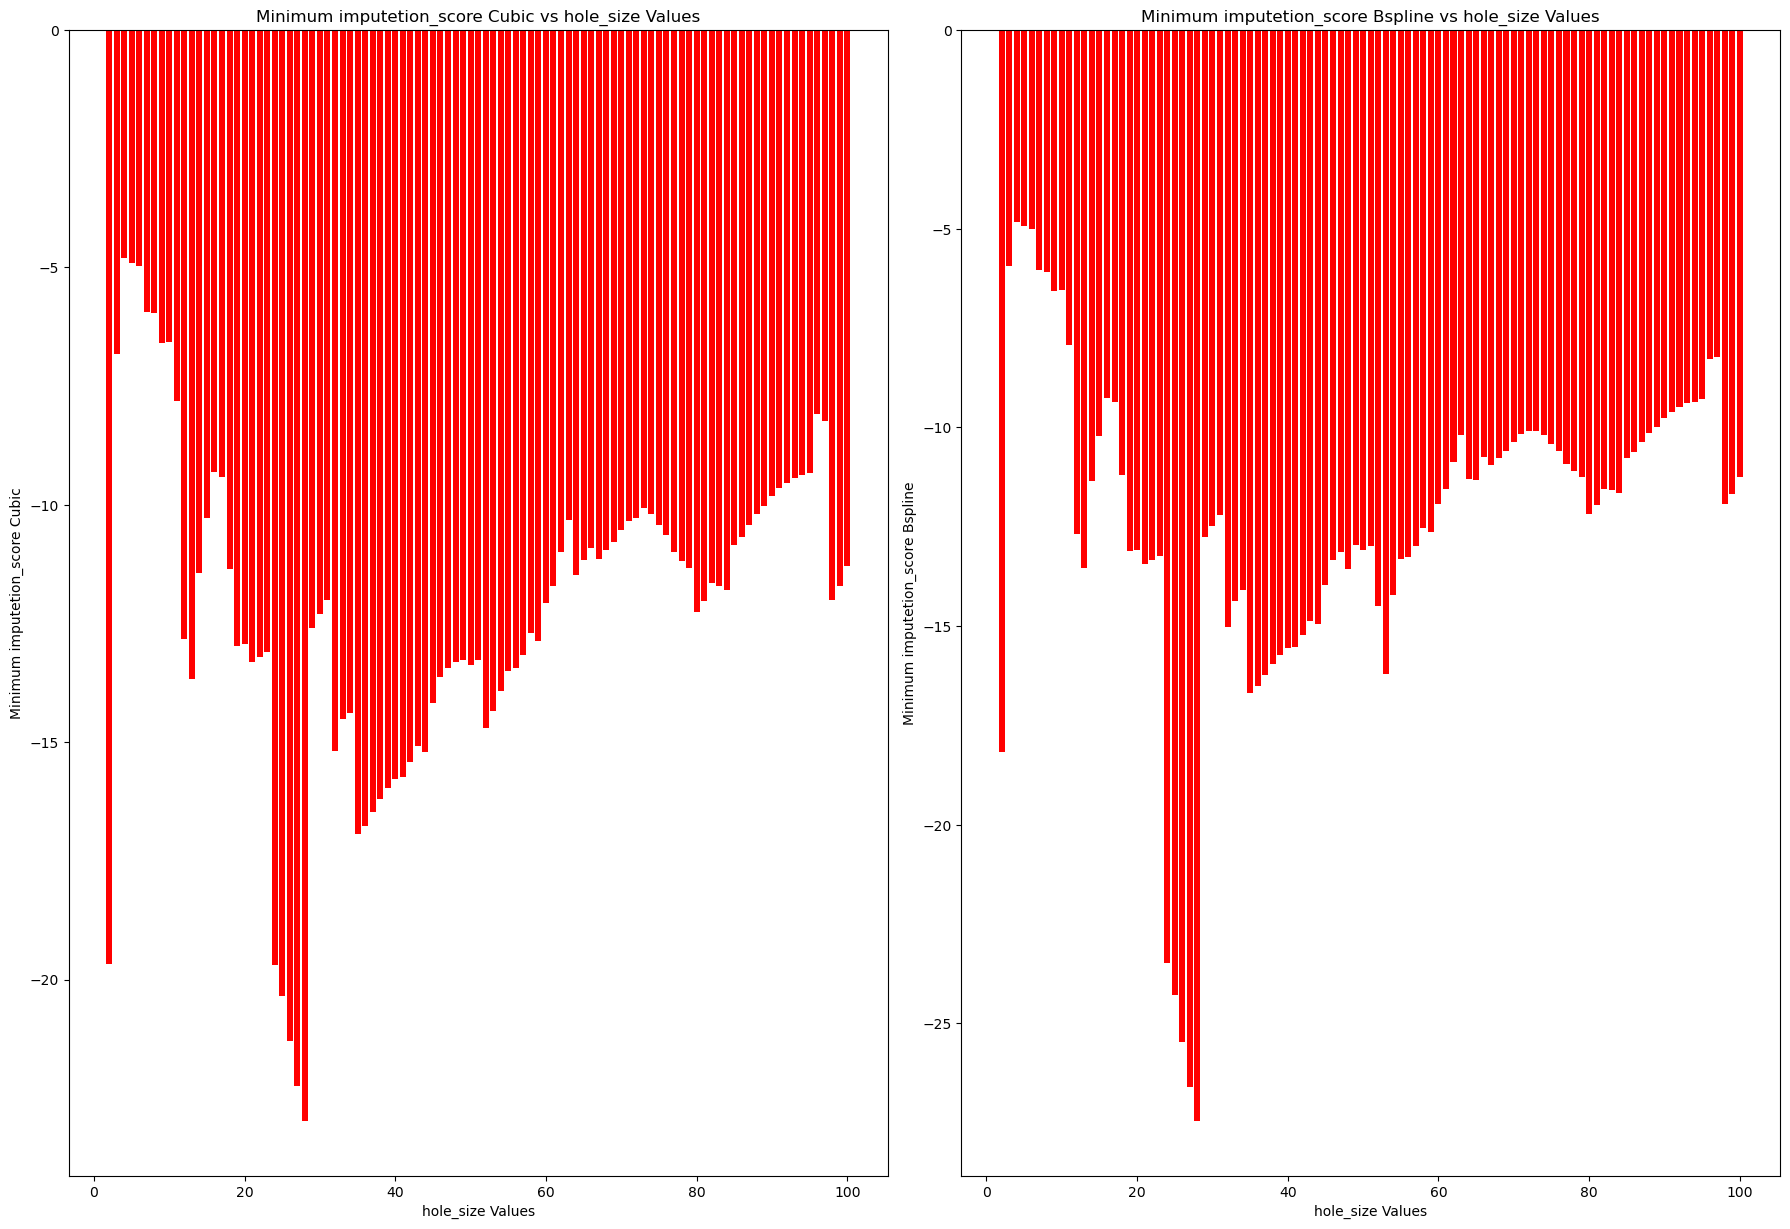

In [109]:
# Plotting results only for uniform distribution (results per hole size):
plt.figure(figsize=(18, 30))

# Average plots
plt.subplot(4, 2, 1)
colors = ['green' if val >= 0 else 'red' for val in plot_data['average_imputetion_score_cubic']]
plt.bar(plot_data['hole_size'], plot_data['average_imputetion_score_cubic'], color=colors)
plt.title('Average imputetion_score Cubic vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('Average imputetion_score Cubic')

plt.subplot(4, 2, 2)
colors = ['green' if val >= 0 else 'red' for val in plot_data['average_imputetion_score_bspline']]
plt.bar(plot_data['hole_size'], plot_data['average_imputetion_score_bspline'], color=colors)
plt.title('Average imputetion_score Bspline vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('Average imputetion_score Bspline')

# Median plots
plt.subplot(4, 2, 3)
colors = ['green' if val >= 0 else 'red' for val in plot_data['median_imputetion_score_cubic']]
plt.bar(plot_data['hole_size'], plot_data['median_imputetion_score_cubic'], color=colors)
plt.title('Median imputetion_score Cubic vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('Median imputetion_score Cubic')

plt.subplot(4, 2, 4)
colors = ['green' if val >= 0 else 'red' for val in plot_data['median_imputetion_score_bspline']]
plt.bar(plot_data['hole_size'], plot_data['median_imputetion_score_bspline'], color=colors)
plt.title('Median imputetion_score Bspline vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('Median imputetion_score Bspline')

# perc_pos plots:
plt.subplot(4, 2, 5)
colors = ['green' if val >= 0 else 'red' for val in plot_data['perc_pos_imputetion_score_cubic']]
plt.bar(plot_data['hole_size'], plot_data['perc_pos_imputetion_score_cubic'], color=colors)
plt.title('perc_pos imputetion score cubic vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('perc_pos_imputetion_score Cubic')

#precent of positive scores:
plt.subplot(4, 2, 6)
colors = ['green' if val >= 0 else 'red' for val in plot_data['perc_pos_imputetion_score_bspline']]
plt.bar(plot_data['hole_size'], plot_data['perc_pos_imputetion_score_bspline'], color=colors)
plt.title('perc_pos_imputetion_score Bspline vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('perc_pos_imputetion_score Bspline')

# Standard deviation plots
plt.subplot(4, 2, 7)
plt.bar(plot_data['hole_size'], plot_data['std_imputetion_score_cubic'])
plt.title('Standard Deviation imputetion_score Cubic vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('Standard Deviation imputetion_score Cubic')

plt.subplot(4, 2, 8)
plt.bar(plot_data['hole_size'], plot_data['std_imputetion_score_bspline'])
plt.title('Standard Deviation imputetion_score Bspline vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('Standard Deviation imputetion_score Bspline')

# Minimum plots
plt.figure(figsize=(18, 24))

plt.subplot(2, 2, 1)
colors = ['green' if val >= 0 else 'red' for val in plot_data['min_imputetion_score_cubic']]
plt.bar(plot_data['hole_size'], plot_data['min_imputetion_score_cubic'], color=colors)
plt.title('Minimum imputetion_score Cubic vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('Minimum imputetion_score Cubic')

plt.subplot(2, 2, 2)
colors = ['green' if val >= 0 else 'red' for val in plot_data['min_imputetion_score_bspline']]
plt.bar(plot_data['hole_size'], plot_data['min_imputetion_score_bspline'], color=colors)
plt.title('Minimum imputetion_score Bspline vs hole_size Values')
plt.xlabel('hole_size Values')
plt.ylabel('Minimum imputetion_score Bspline')

plt.tight_layout()
plt.show()


**Winning ratio between the two methods**

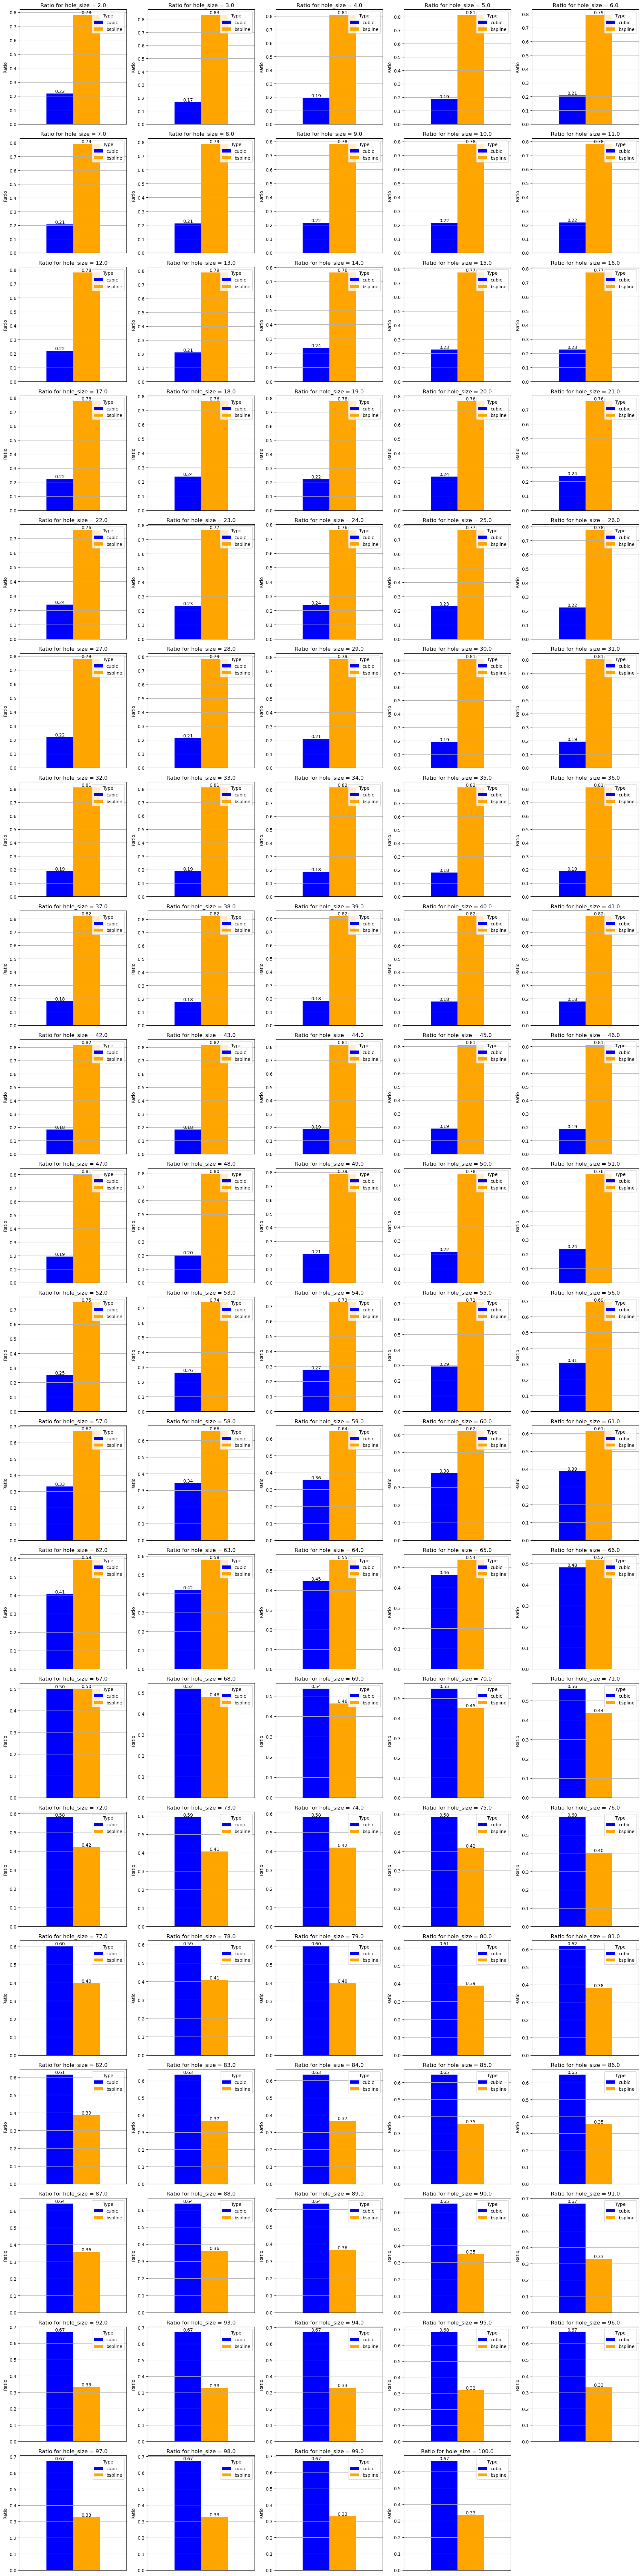

In [110]:
# Get all unique hole sizes across all hole_size columns
unique_hole_sizes = sorted(set().union(*[results_df_uniform[f'hole_size_{j}'].dropna().unique() for j in range(1, 5)]))

# Determine the number of plots based on the number of unique hole sizes
total_plots = len(unique_hole_sizes)

# Calculate the number of rows needed (e.g., 5 columns per row)
ncols = 5
nrows = (total_plots // ncols) + (1 if total_plots % ncols != 0 else 0)

# Set consistent colors for cubic and bspline
colors = {'cubic': 'blue', 'bspline': 'orange'}

# Create a figure with the determined number of rows and 5 columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop over each unique hole size
for plot_index, hole_size_value in enumerate(unique_hole_sizes):
    cumulative_victories_cubic = 0
    cumulative_victories_bspline = 0
    total_comparisons = 0

    # Collect the ratios for each hole size across all cycle columns
    for j in range(1, 5):
        hole_size_df = results_df_uniform[results_df_uniform[f'hole_size_{j}'] == hole_size_value]
        cubic_col = f'imputetion_score_cubic_{j}'
        bspline_col = f'imputetion_score_bspline_{j}'

        # Calculate victories for the current hole size and cycle
        if not hole_size_df.empty:
            victories_cubic = (hole_size_df[cubic_col] > hole_size_df[bspline_col]).sum()
            victories_bspline = (hole_size_df[bspline_col] > hole_size_df[cubic_col]).sum()
            comparisons = len(hole_size_df)

            cumulative_victories_cubic += victories_cubic
            cumulative_victories_bspline += victories_bspline
            total_comparisons += comparisons

    # Calculate the final victory ratios for the current hole size
    if total_comparisons > 0:
        final_ratio_cubic = cumulative_victories_cubic / total_comparisons
        final_ratio_bspline = cumulative_victories_bspline / total_comparisons
    else:
        final_ratio_cubic = final_ratio_bspline = 0

    # Create a DataFrame for easier plotting
    ratios_df = pd.DataFrame({
        f'hole_size_{hole_size_value}': [final_ratio_cubic, final_ratio_bspline]
    }, index=['cubic', 'bspline']).T

    # Plot bar plot for the current hole_size value
    ax = axes[plot_index]
    bar_plot = ratios_df.plot(kind='bar', ax=ax, color=[colors['cubic'], colors['bspline']])
    ax.set_title(f'Ratio for hole_size = {hole_size_value}')
    ax.set_ylabel('Ratio')
    ax.grid(True)
    ax.legend(['cubic', 'bspline'], title='Type', loc='upper right')
    ax.set_xticks([])

    # Add text labels on top of the bars
    for p in bar_plot.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Hide any unused subplots
for ax in axes[plot_index + 1:]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**General results from the original distribution:**

Overall victory ratio for Cubic: 19.67%
Overall victory ratio for B-Spline: 80.33%


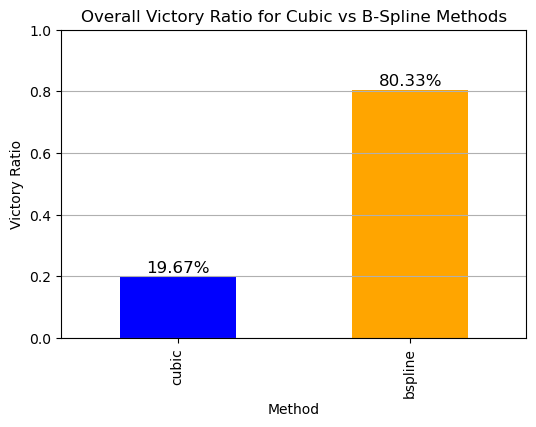

In [111]:
# Combine all imputation scores for cubic and b-spline across all cycles
cubic_scores = pd.concat([results_df_original[f'imputetion_score_cubic_{i}'].dropna() for i in range(1, 5)])
bspline_scores = pd.concat([results_df_original[f'imputetion_score_bspline_{i}'].dropna() for i in range(1, 5)])

# Compare cubic and b-spline scores
victories_cubic = (cubic_scores > bspline_scores).sum()
victories_bspline = (bspline_scores > cubic_scores).sum()

# Calculate the total number of comparisons
total_comparisons = len(cubic_scores)

# Calculate the victory ratio for cubic and b-spline methods
victory_ratio_cubic = victories_cubic / total_comparisons
victory_ratio_bspline = victories_bspline / total_comparisons

# Display the results
print(f"Overall victory ratio for Cubic: {victory_ratio_cubic:.2%}")
print(f"Overall victory ratio for B-Spline: {victory_ratio_bspline:.2%}")

# Prepare the data for plotting
overall_victory_ratio = pd.Series({'cubic': victory_ratio_cubic, 'bspline': victory_ratio_bspline})

# Plot the ratio
plt.figure(figsize=(6, 4))
overall_victory_ratio.plot(kind='bar', color=['blue', 'orange'])

# Add title and labels
plt.title('Overall Victory Ratio for Cubic vs B-Spline Methods')
plt.xlabel('Method')
plt.ylabel('Victory Ratio')

# Display the ratio values on top of the bars
for i, ratio in enumerate(overall_victory_ratio):
    plt.text(i, ratio + 0.005, f'{ratio:.2%}', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.ylim(0, 1)  # Set y-limit between 0 and 1 for percentage
plt.grid(axis='y')
plt.show()